# 加载和预处理数据

https://www.tensorflow.org/tutorials/load_data/csv

- [1. 加载CSV的数据 tf.data.experimental.make_csv_dataset](#1.加载CSV的数据)
- [2. 加载numpy的数据 tf.keras.utils.get_file](#2.加载numpy的数据)
- [3. 加载pandas的数据](#3.加载pandas的数据)
- [4. 加载图片数据 tf.image.decode_image](#4.加载图片数据)
- [5. 加载文本数据](#5.加载文本数据)

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import functools

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import os

# 1.加载CSV的数据

[回到目录](#加载和预处理数据)

In [3]:
TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

train_file_path = tf.keras.utils.get_file("train.csv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("eval.csv", TEST_DATA_URL)

# 让 numpy 数据更易读。
np.set_printoptions(precision=3, suppress=True)

In [4]:
!head {train_file_path}

survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.25,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
1,female,26.0,0,0,7.925,Third,unknown,Southampton,y
1,female,35.0,1,0,53.1,First,C,Southampton,n
0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
0,male,2.0,3,1,21.075,Third,unknown,Southampton,n
1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n
1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n
1,female,4.0,1,1,16.7,Third,G,Southampton,n


In [5]:
train_file_path

'/root/.keras/datasets/train.csv'

In [6]:
LABEL_COLUMN = 'survived'
LABELS = [0, 1]

# column_names 当文件无head时，可定义列名
# select_columns 选择自己需要读取哪些列

def get_dataset(file_path):
    dataset = tf.data.experimental.make_csv_dataset(
      file_path,
      batch_size=12, # 为了示例更容易展示，手动设置较小的值
      label_name=LABEL_COLUMN,
      na_value="?",
      num_epochs=1,
      ignore_errors=True)
    return dataset

raw_train_data = get_dataset(train_file_path)
raw_test_data = get_dataset(test_file_path)

W0110 13:00:11.256311 139930429216576 deprecation.py:323] From /usr/local/python3/lib/python3.6/site-packages/tensorflow/python/data/experimental/ops/readers.py:498: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


In [7]:
"""
dataset 中的每个条目都是一个批次，用一个元组（多个样本，多个标签）表示。
样本中的数据组织形式是以列为主的张量（而不是以行为主的张量），每条数据中包含的元素个数就是批次大小（这个示例中是 12）
"""
examples, labels = next(iter(raw_train_data)) # 第一个批次
print("EXAMPLES: \n", examples, "\n")
print("LABELS: \n", labels)

EXAMPLES: 
 OrderedDict([('sex', <tf.Tensor: id=170, shape=(12,), dtype=string, numpy=
array([b'male', b'female', b'male', b'male', b'female', b'male',
       b'female', b'female', b'male', b'male', b'male', b'male'],
      dtype=object)>), ('age', <tf.Tensor: id=162, shape=(12,), dtype=float32, numpy=
array([24., 30., 28., 52., 24., 22., 28., 31., 37., 32., 46., 28.],
      dtype=float32)>), ('n_siblings_spouses', <tf.Tensor: id=168, shape=(12,), dtype=int32, numpy=array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32)>), ('parch', <tf.Tensor: id=169, shape=(12,), dtype=int32, numpy=array([0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0], dtype=int32)>), ('fare', <tf.Tensor: id=167, shape=(12,), dtype=float32, numpy=
array([13.   , 24.15 ,  0.   , 30.5  , 14.5  ,  7.229, 33.   , 18.   ,
       29.7  ,  7.75 , 26.   ,  7.75 ], dtype=float32)>), ('class', <tf.Tensor: id=164, shape=(12,), dtype=string, numpy=
array([b'Second', b'Third', b'Second', b'First', b'Second', b'Third',
       b'Second', b'

In [9]:
type(raw_train_data)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [10]:
# 预处理数据

# 1.处理离散值列
CATEGORIES = {
    'sex': ['male', 'female'],
    'class' : ['First', 'Second', 'Third'],
    'deck' : ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    'embark_town' : ['Cherbourg', 'Southhampton', 'Queenstown'],
    'alone' : ['y', 'n']
}

# 使用 tf.feature_column API 创建一个 tf.feature_column.indicator_column 集合
# 每个 tf.feature_column.indicator_column 对应一个分类的列。
categorical_columns = []
for feature, vocab in CATEGORIES.items():
    cat_col = tf.feature_column.categorical_column_with_vocabulary_list(key=feature, vocabulary_list=vocab)
    categorical_columns.append(tf.feature_column.indicator_column(cat_col))

print(categorical_columns)

# 2.处理连续值列
def process_continuous_data(mean, data):
    # 标准化数据, 改造成 2 维的张量
    data = tf.cast(data, tf.float32) * 1/(2*mean)
    return tf.reshape(data, [-1, 1])

MEANS = {
    'age' : 29.631308,
    'n_siblings_spouses' : 0.545455,
    'parch' : 0.379585,
    'fare' : 34.385399
}

numerical_columns = []

# tf.feature_columns.numeric_column API 会使用 normalizer_fn 参数
for feature in MEANS.keys():
    num_col = tf.feature_column.numeric_column(feature, normalizer_fn=functools.partial(process_continuous_data, MEANS[feature]))
    numerical_columns.append(num_col)
    
print(numerical_columns)

# 3.创建预处理层
preprocessing_layer = tf.keras.layers.DenseFeatures(categorical_columns + numerical_columns)


[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='class', vocabulary_list=('First', 'Second', 'Third'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='deck', vocabulary_list=('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Cherbourg', 'Southhampton', 'Queenstown'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='alone', vocabulary_list=('y', 'n'), dtype=tf.string, default_value=-1, num_oov_buckets=0))]
[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, n

In [11]:
# 构建模型
model = tf.keras.Sequential([
  preprocessing_layer,
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

# 训练
train_data = raw_train_data.shuffle(500)
model.fit(train_data, epochs=20)


# 评估
test_data = raw_test_data
test_loss, test_accuracy = model.evaluate(test_data)
print('\n\nTest Loss {}, Test Accuracy {}'.format(test_loss, test_accuracy))

Epoch 1/20


W0110 13:36:48.985358 139930429216576 deprecation.py:323] From /usr/local/python3/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:2655: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0110 13:36:49.006904 139930429216576 deprecation.py:323] From /usr/local/python3/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:4215: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0110 13:36:49.007874 139930429216576 deprecation.py:323] From /usr/local/python3/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:4

53/53 [==============================] - 2s 46ms/step - loss: 0.5376 - accuracy: 0.6545
Epoch 2/20
53/53 [==============================] - 0s 4ms/step - loss: 0.4399 - accuracy: 0.8311
Epoch 3/20
53/53 [==============================] - 0s 3ms/step - loss: 0.4204 - accuracy: 0.8362
Epoch 4/20
53/53 [==============================] - 0s 3ms/step - loss: 0.4091 - accuracy: 0.8414
Epoch 5/20
53/53 [==============================] - 0s 3ms/step - loss: 0.4002 - accuracy: 0.8437
Epoch 6/20
53/53 [==============================] - 0s 3ms/step - loss: 0.3918 - accuracy: 0.8383
Epoch 7/20
53/53 [==============================] - 0s 3ms/step - loss: 0.3850 - accuracy: 0.8394
Epoch 8/20
53/53 [==============================] - 0s 3ms/step - loss: 0.3787 - accuracy: 0.8372
Epoch 9/20
53/53 [==============================] - 0s 3ms/step - loss: 0.3731 - accuracy: 0.8439
Epoch 10/20
53/53 [==============================] - 0s 3ms/step - loss: 0.3681 - accuracy: 0.8314
Epoch 11/20
53/53 [==========

In [12]:
# 预测
predictions = model.predict(test_data)

# 显示部分结果
for prediction, survived in zip(predictions[:10], list(test_data)[0][1][:10]):
    print("Predicted survival: {:.2%}".format(prediction[0]),
        " | Actual outcome: ", ("SURVIVED" if bool(survived) else "DIED"))

Predicted survival: 43.08%  | Actual outcome:  DIED
Predicted survival: 9.94%  | Actual outcome:  DIED
Predicted survival: 8.65%  | Actual outcome:  DIED
Predicted survival: 78.66%  | Actual outcome:  DIED
Predicted survival: 39.52%  | Actual outcome:  SURVIVED
Predicted survival: 23.32%  | Actual outcome:  DIED
Predicted survival: 10.09%  | Actual outcome:  DIED
Predicted survival: 18.93%  | Actual outcome:  DIED
Predicted survival: 0.49%  | Actual outcome:  DIED
Predicted survival: 87.72%  | Actual outcome:  SURVIVED


# 2.加载numpy的数据

[回到目录](#加载和预处理数据)

In [13]:
DATA_URL = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'

path = tf.keras.utils.get_file('mnist.npz', DATA_URL)
with np.load(path) as data:
    train_examples = data['x_train']
    train_labels = data['y_train']
    test_examples = data['x_test']
    test_labels = data['y_test']
    
train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

print("**********training*************")

model.fit(train_dataset, epochs=10)

print("**********evaluate*************")

model.evaluate(test_dataset)

**********training*************
Epoch 1/10
938/938 [==============================] - 4s 5ms/step - loss: 6.2252 - sparse_categorical_accuracy: 0.6097
Epoch 2/10
938/938 [==============================] - 4s 4ms/step - loss: 5.5488 - sparse_categorical_accuracy: 0.6538
Epoch 3/10
938/938 [==============================] - 3s 4ms/step - loss: 5.4301 - sparse_categorical_accuracy: 0.6616
Epoch 4/10
938/938 [==============================] - 3s 4ms/step - loss: 5.3993 - sparse_categorical_accuracy: 0.6636
Epoch 5/10
938/938 [==============================] - 3s 4ms/step - loss: 5.3664 - sparse_categorical_accuracy: 0.6659
Epoch 6/10
938/938 [==============================] - 3s 4ms/step - loss: 5.3275 - sparse_categorical_accuracy: 0.6684
Epoch 7/10
938/938 [==============================] - 3s 4ms/step - loss: 5.2745 - sparse_categorical_accuracy: 0.6719
Epoch 8/10
938/938 [==============================] - 3s 4ms/step - loss: 5.2333 - sparse_categorical_accuracy: 0.6744
Epoch 9/10
938/9

[5.098125600511102, 0.6827]

# 3.加载pandas的数据

[回到目录](#加载和预处理数据)

In [3]:
import pandas as pd

csv_file = tf.keras.utils.get_file('heart.csv', 'https://storage.googleapis.com/applied-dl/heart.csv')
df = pd.read_csv(csv_file)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [4]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal         object
target        int64
dtype: object

In [5]:
# 处理object的列
df['thal'] = pd.Categorical(df['thal'])
df['thal'] = df.thal.cat.codes

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,2,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,4,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [6]:
target = df.pop('target')

dataset = tf.data.Dataset.from_tensor_slices((df.values, target.values))

for feat, targ in dataset.take(5):
    print ('Features: {}, Target: {}'.format(feat, targ))

Features: [ 63.    1.    1.  145.  233.    1.    2.  150.    0.    2.3   3.    0.
   2. ], Target: 0
Features: [ 67.    1.    4.  160.  286.    0.    2.  108.    1.    1.5   2.    3.
   3. ], Target: 1
Features: [ 67.    1.    4.  120.  229.    0.    2.  129.    1.    2.6   2.    2.
   4. ], Target: 0
Features: [ 37.    1.    3.  130.  250.    0.    0.  187.    0.    3.5   3.    0.
   3. ], Target: 0
Features: [ 41.    0.    2.  130.  204.    0.    2.  172.    0.    1.4   1.    0.
   3. ], Target: 0


In [7]:
tf.constant(df['thal'])

<tf.Tensor: id=31, shape=(303,), dtype=int32, numpy=
array([2, 3, 4, 3, 3, 3, 3, 3, 4, 4, 2, 3, 2, 4, 4, 3, 4, 3, 3, 3, 3, 3,
       3, 4, 4, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 4, 2, 4, 3, 4, 3, 4, 4,
       2, 3, 3, 4, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 4,
       4, 2, 3, 3, 4, 3, 4, 3, 3, 4, 4, 3, 3, 4, 4, 3, 3, 3, 3, 4, 4, 4,
       3, 3, 4, 3, 4, 4, 3, 4, 3, 3, 3, 4, 3, 4, 4, 3, 3, 4, 4, 4, 4, 4,
       3, 3, 3, 3, 4, 3, 4, 3, 4, 4, 3, 3, 2, 4, 4, 2, 3, 3, 4, 4, 3, 4,
       3, 3, 4, 2, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       4, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 2,
       4, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 2, 2, 4, 3, 4, 2, 4, 3,
       3, 4, 3, 3, 3, 3, 4, 3, 4, 3, 4, 2, 2, 4, 3, 4, 3, 2, 4, 3, 3, 2,
       4, 4, 4, 4, 3, 0, 3, 3, 3, 3, 1, 4, 3, 3, 3, 4, 3, 4, 3, 3, 3, 4,
       3, 3, 4, 4, 4, 4, 3, 3, 4, 3, 4, 3, 4, 4, 3, 4, 4, 3, 4, 4, 3, 3

In [22]:
train_dataset = dataset.shuffle(len(df)).batch(1)

def get_compiled_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
        ])

    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
    return model

model = get_compiled_model()
model.fit(train_dataset, epochs=15)


Epoch 1/15
303/303 [==============================] - 2s 5ms/step - loss: 4.2253 - accuracy: 0.6677
Epoch 2/15
303/303 [==============================] - 1s 2ms/step - loss: 4.2253 - accuracy: 0.6677
Epoch 3/15
303/303 [==============================] - 1s 2ms/step - loss: 4.2253 - accuracy: 0.6677
Epoch 4/15
303/303 [==============================] - 1s 2ms/step - loss: 4.2253 - accuracy: 0.6677
Epoch 5/15
303/303 [==============================] - 1s 2ms/step - loss: 4.2253 - accuracy: 0.6677
Epoch 6/15
303/303 [==============================] - 1s 2ms/step - loss: 4.2253 - accuracy: 0.6677
Epoch 7/15
303/303 [==============================] - 1s 2ms/step - loss: 4.2253 - accuracy: 0.6677
Epoch 8/15
303/303 [==============================] - 1s 2ms/step - loss: 4.2253 - accuracy: 0.6677
Epoch 9/15
303/303 [==============================] - 1s 2ms/step - loss: 4.2253 - accuracy: 0.6677
Epoch 10/15
303/303 [==============================] - 1s 2ms/step - loss: 4.2253 - accuracy: 0.6677

**另一种方法**

In [8]:
"""
将字典作为输入传输给模型就像创建 tf.keras.layers.Input 层的匹配字典一样简单，应用任何预处理并使用 functional api
"""
inputs = {key: tf.keras.layers.Input(shape=(), name=key) for key in df.keys()}  # 每一列都构成一个tensor
x = tf.stack(list(inputs.values()), axis=-1)    # <tf.Tensor 'stack:0' shape=(None, 13) dtype=float32>

x = tf.keras.layers.Dense(10, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_func = tf.keras.Model(inputs=inputs, outputs=output)
model_func.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [9]:
"""
与 tf.data 一起使用时，保存 pd.DataFrame 列结构的最简单方法是将 pd.DataFrame 转换为 dict ，并对该字典进行切片。
"""
dict_slices = tf.data.Dataset.from_tensor_slices((df.to_dict('list'), target.values)).batch(16)
for dict_slice in dict_slices.take(1):
    print (dict_slice)

({'age': <tf.Tensor: id=207, shape=(16,), dtype=int32, numpy=
array([63, 67, 67, 37, 41, 56, 62, 57, 63, 53, 57, 56, 56, 44, 52, 57],
      dtype=int32)>, 'sex': <tf.Tensor: id=215, shape=(16,), dtype=int32, numpy=array([1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int32)>, 'cp': <tf.Tensor: id=210, shape=(16,), dtype=int32, numpy=array([1, 4, 4, 3, 2, 2, 4, 4, 4, 4, 4, 2, 3, 2, 3, 3], dtype=int32)>, 'trestbps': <tf.Tensor: id=219, shape=(16,), dtype=int32, numpy=
array([145, 160, 120, 130, 130, 120, 140, 120, 130, 140, 140, 140, 130,
       120, 172, 150], dtype=int32)>, 'chol': <tf.Tensor: id=209, shape=(16,), dtype=int32, numpy=
array([233, 286, 229, 250, 204, 236, 268, 354, 254, 203, 192, 294, 256,
       263, 199, 168], dtype=int32)>, 'fbs': <tf.Tensor: id=212, shape=(16,), dtype=int32, numpy=array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0], dtype=int32)>, 'restecg': <tf.Tensor: id=214, shape=(16,), dtype=int32, numpy=array([2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0

In [31]:
model_func.fit(dict_slices, epochs=15)

W0110 15:26:08.238927 139930429216576 training_utils.py:1436] Expected a shuffled dataset but input dataset `x` is not shuffled. Please invoke `shuffle()` on input dataset.


Epoch 1/15
19/19 [==============================] - 1s 46ms/step - loss: 3.6114 - accuracy: 0.7261
Epoch 2/15
19/19 [==============================] - 0s 5ms/step - loss: 2.0943 - accuracy: 0.7129
Epoch 3/15
19/19 [==============================] - 0s 5ms/step - loss: 1.2708 - accuracy: 0.7261
Epoch 4/15
19/19 [==============================] - 0s 4ms/step - loss: 1.2179 - accuracy: 0.7129
Epoch 5/15
19/19 [==============================] - 0s 4ms/step - loss: 1.1629 - accuracy: 0.7228
Epoch 6/15
19/19 [==============================] - 0s 4ms/step - loss: 1.1239 - accuracy: 0.7162
Epoch 7/15
19/19 [==============================] - 0s 4ms/step - loss: 1.0884 - accuracy: 0.7195
Epoch 8/15
19/19 [==============================] - 0s 4ms/step - loss: 1.0524 - accuracy: 0.7195
Epoch 9/15
19/19 [==============================] - 0s 4ms/step - loss: 1.0171 - accuracy: 0.7195
Epoch 10/15
19/19 [==============================] - 0s 4ms/step - loss: 0.9839 - accuracy: 0.7162
Epoch 11/15
19/19 

# 4.加载图片数据

- [4.1 下载图像数据](#4.1下载图像数据)
- [4.2 构建tf.data.Dataset](#4.2构建tf.data.Dataset)
- [4.3 性能优化](#4.3性能优化)

[回到目录](#加载和预处理数据)

# 4.1下载图像数据

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

/root/.keras/datasets/flower_photos


In [6]:
for item in data_root.iterdir():
    print(item)

/root/.keras/datasets/flower_photos/roses
/root/.keras/datasets/flower_photos/sunflowers
/root/.keras/datasets/flower_photos/LICENSE.txt
/root/.keras/datasets/flower_photos/tulips
/root/.keras/datasets/flower_photos/daisy
/root/.keras/datasets/flower_photos/dandelion


In [7]:
import random
all_image_paths = list(data_root.glob('*/*'))   # 获取所有图片路径
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print(image_count)

all_image_paths[:10]

3670


['/root/.keras/datasets/flower_photos/roses/6231418894_7946a7712b_n.jpg',
 '/root/.keras/datasets/flower_photos/roses/16374919860_4e445de29f_n.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/3585220976_5acac92d1c.jpg',
 '/root/.keras/datasets/flower_photos/daisy/2057816617_18448093d0_n.jpg',
 '/root/.keras/datasets/flower_photos/tulips/8622237974_b362574785_n.jpg',
 '/root/.keras/datasets/flower_photos/sunflowers/26254755_1bfc494ef1_n.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/2294126841_e478564e77_n.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/8749577087_dc2521615f_n.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/3823142577_dd5acd5ac6_n.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/8376558865_19c5cd6fd6_n.jpg']

**看一下图片**

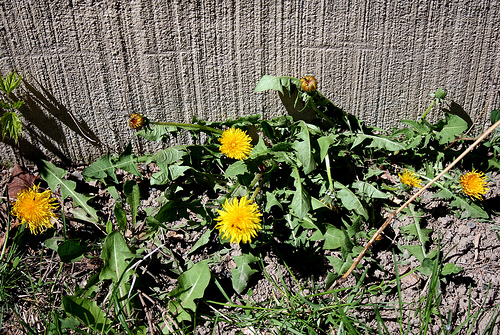

Image (CC BY 2.0)  by Robert Taylor



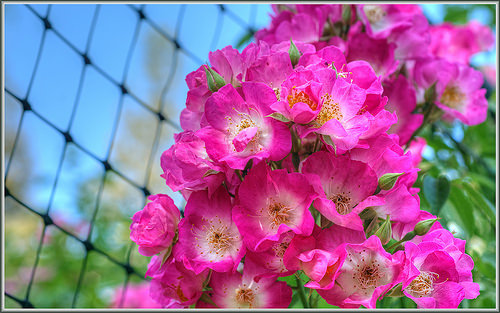

Image (CC BY 2.0)  by tdlucas5000



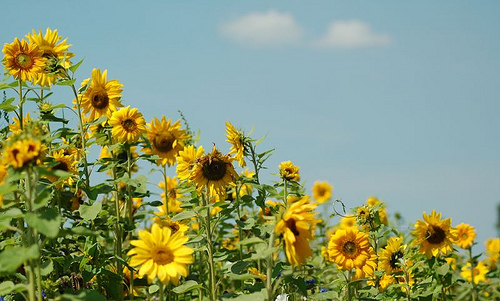

Image (CC BY 2.0)  by Frank de Kleine



In [8]:
import os
attributions = (data_root/"LICENSE.txt").open(encoding='utf-8').readlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)   # 'daisy/7568630428_8cf0fc16ff_n.jpg': ' by A Guy Taking Pictures - https://www.flickr.com/photos/80901381@N04/7568630428/\n'

import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])

for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    print(caption_image(image_path))
    print()

**处理标签**

In [9]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
print(label_names)

# 分配标签索引
label_to_index = dict((name, index) for index, name in enumerate(label_names))
print(label_to_index)

all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
First 10 labels indices:  [2, 2, 1, 0, 4, 3, 1, 1, 1, 1]


**加载和格式化图片**

/root/.keras/datasets/flower_photos/roses/6231418894_7946a7712b_n.jpg
<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x...
(240, 320, 3)
<dtype: 'uint8'>
(192, 192, 3)
0.0
0.99640524



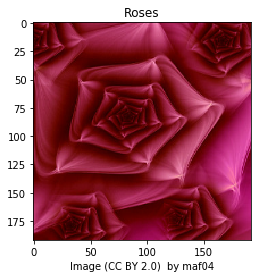

In [10]:
img_path = all_image_paths[0]
print(img_path)

img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

# 解码为图像 tensor（张量）
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)

# 调整大小 及 标准化
img_final = tf.image.resize(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

#******************封装成函数******************
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0  # normalize to [0,1] range
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

import matplotlib.pyplot as plt
%matplotlib inline

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path))
plt.title(label_names[label].title())
print()

# 4.2构建tf.data.Dataset

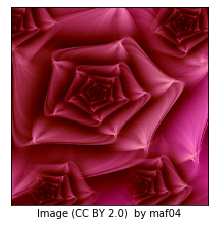

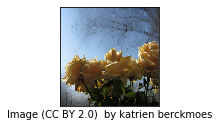

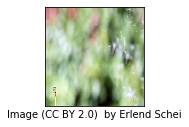

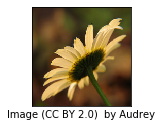

In [11]:
# 1.图片数据集
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)  # 读取图片数据

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(caption_image(all_image_paths[n]))
  plt.show()

In [12]:
# 2.标签数据集
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

for label in label_ds.take(10):
    print(label_names[label.numpy()])

roses
roses
dandelion
daisy
tulips
sunflowers
dandelion
dandelion
dandelion
dandelion


In [13]:
# 3.合并 （图像，标签）
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [14]:
# 上述处理的另一种方式，放在一起处理
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# 元组被解压缩到映射函数的位置参数中
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
print(image_label_ds)

<MapDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>


In [15]:
BATCH_SIZE = 32

# 设置一个和数据集大小一致的 shuffle buffer size（随机缓冲区大小）以保证数据
# 被充分打乱。
# ds = image_label_ds.shuffle(buffer_size=image_count)
# ds = ds.repeat()

"""
为什么不用ds = image_label_ds.shuffle(buffer_size=image_count).repeat()？
"""

ds = image_label_ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
# 当模型在训练的时候，`prefetch` 使数据集在后台取得 batch。
ds = ds.prefetch(buffer_size=AUTOTUNE)
print(ds)

W0113 13:27:30.556589 140666527196992 deprecation.py:323] From <ipython-input-15-1224c489f5b9>:12: shuffle_and_repeat (from tensorflow.python.data.experimental.ops.shuffle_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>


❤一些注意事项：

- 顺序很重要。

    - 在 .repeat 之后 .shuffle，会在 epoch 之间打乱数据（当有些数据出现两次的时候，其他数据还没有出现过）。

    - 在 .batch 之后 .shuffle，会打乱 batch 的顺序，但是不会在 batch 之间打乱数据。

- 你在完全打乱中使用和数据集大小一样的 buffer_size（缓冲区大小）。较大的缓冲区大小提供更好的随机化，但使用更多的内存，直到超过数据集大小。

- 在从随机缓冲区中拉取任何元素前，要先填满它。所以当你的 Dataset（数据集）启动的时候一个大的 buffer_size（缓冲区大小）可能会引起延迟。

- 在随机缓冲区完全为空之前，被打乱的数据集不会报告数据集的结尾。Dataset（数据集）由 .repeat 重新启动，导致需要再次等待随机缓冲区被填满。

最后一点可以通过使用 `tf.data.Dataset.apply` 方法和融合过的 `tf.data.experimental.shuffle_and_repeat` 函数来解决

**先看一个批次的数据**

In [18]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)

# 设置 MobileNet 的权重为不可训练
mobile_net.trainable=False


# Mobilenet期望它的输出被标准化至 [-1,1] 范围内
def change_range(image,label):
    return 2*image-1, label
keras_ds = ds.map(change_range)

# MobileNet 为每张图片的特征返回一个 6x6 的空间网格，传递一个batch看一下结果
image_batch, label_batch = next(iter(keras_ds))
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names), activation = 'softmax')])

logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

(32, 6, 6, 1280)
min logit: 0.003317871
max logit: 0.94776905

Shape: (32, 5)


**出于演示目的每一个 epoch 中只运行 3 step，但一般来说在传递给 model.fit() 之前你会指定 step 的真实数量**

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])
print(len(model.trainable_variables)) #只有最后一层有待训练权重
model.summary()

steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
print(steps_per_epoch)

model.fit(ds, epochs=1, steps_per_epoch=3)

2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________
115.0


W0113 13:32:13.516379 140666527196992 deprecation.py:323] From /usr/local/python3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


3/3 [==============================] - 11s 4s/step - loss: 1.9146 - accuracy: 0.1667


# 4.3性能优化
- 利用缓存 
- [TFRecord文件](#TFRecord文件)

上面使用的简单 pipeline（管道）在每个 epoch 中单独读取每个文件。在本地使用 CPU 训练时这个方法是可行的，**但是可能不足以进行 GPU 训练并且完全不适合任何形式的分布式训练**。

要研究这点，首先构建一个简单的函数来检查数据集的性能

In [20]:
import time
default_timeit_steps = 2*steps_per_epoch+1

def timeit(ds, steps=default_timeit_steps):
  overall_start = time.time()
  # 在开始计时之前
  # 取得单个 batch 来填充 pipeline（管道）（填充随机缓冲区）
  it = iter(ds.take(steps+1))
  next(it)

  start = time.time()
  for i,(images,labels) in enumerate(it):
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))
  print("Total time: {}s".format(end-overall_start))

In [21]:
ds = image_label_ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
print(ds)

# 当前效率
timeit(ds)

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>
........................
231.0 batches: 14.680429697036743 s
503.52750 Images/s
Total time: 22.04440450668335s


### 利用缓存

使用 tf.data.Dataset.cache 在 epoch 之间轻松缓存计算结果。这是非常高效的，特别是当内存能容纳全部数据时。

在被预处理之后（解码和调整大小），图片在此被缓存了：

In [22]:
ds = image_label_ds.cache()         # ★★
ds = ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
print(ds)

timeit(ds)

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>
........................
231.0 batches: 0.63802170753479 s
11585.81270 Images/s
Total time: 8.330419540405273s


**使用内存缓存的一个缺点是必须在每次运行时重建缓存，这使得每次启动数据集时有相同的启动延迟**

In [23]:
timeit(ds)

........................
231.0 batches: 0.622952938079834 s
11866.06491 Images/s
Total time: 7.93975567817688s


❤ **如果内存不够容纳数据，使用一个缓存文件**

In [24]:
ds = image_label_ds.cache(filename='./cache.tf-data')       # ★★★★★
ds = ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(1)
print(ds)

timeit(ds)

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>
........................
231.0 batches: 3.793809175491333 s
1948.43748 Images/s
Total time: 17.626397848129272s


**这个缓存文件也有可快速重启数据集而无需重建缓存的优点。注意第二次快了多少**

In [25]:
timeit(ds)

........................
231.0 batches: 2.4209396839141846 s
3053.35984 Images/s
Total time: 3.880500078201294s


### TFRecord文件

TFRecord 文件是一种用来存储一串二进制 blob 的简单格式。

通过将多个示例打包进同一个文件内，TensorFlow 能够一次性读取多个示例，当使用一个远程存储服务，如 GCS 时，这对性能来说尤其重要。

In [26]:
# 从原始图片数据中构建出一个 TFRecord 文件
image_ds = tf.data.Dataset.from_tensor_slices(all_image_paths).map(tf.io.read_file)
tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
tfrec.write(image_ds)

In [28]:
image_ds = tf.data.TFRecordDataset('images.tfrec').map(preprocess_image)

ds = tf.data.Dataset.zip((image_ds, label_ds))
ds = ds.cache(filename='./cache.tf-data')
ds = ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
print(ds)

timeit(ds)

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int64)>
........................
231.0 batches: 2.1950693130493164 s
3367.54742 Images/s
Total time: 3.7048590183258057s


**不是保存原始图片，把预处理之后的图片生成 TFRecord文件**

In [29]:
paths_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = paths_ds.map(load_and_preprocess_image)
print(image_ds)

# 要将此序列化至一个 TFRecord 文件你首先将该 tensor（张量）数据集转化为一个字符串数据集
ds = image_ds.map(tf.io.serialize_tensor)
print(ds)

tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
tfrec.write(ds)

<MapDataset shapes: (192, 192, 3), types: tf.float32>
<MapDataset shapes: (), types: tf.string>


In [30]:
ds = tf.data.TFRecordDataset('images.tfrec')

# 反序列化
def parse(x):
    result = tf.io.parse_tensor(x, out_type=tf.float32)
    result = tf.reshape(result, [192, 192, 3])
    return result

ds = ds.map(parse, num_parallel_calls=AUTOTUNE)
print(ds)

ds = tf.data.Dataset.zip((ds, label_ds))
ds = ds.cache(filename='./cache.tf-data')
ds = ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds=ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
print(ds)

timeit(ds)

<ParallelMapDataset shapes: (192, 192, 3), types: tf.float32>
<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int64)>
........................
231.0 batches: 2.053964853286743 s
3598.89313 Images/s
Total time: 3.492093801498413s


# 5.加载文本数据

[回到目录](#加载和预处理数据)

In [24]:
DIRECTORY_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
FILE_NAMES = ['cowper.txt', 'derby.txt', 'butler.txt']

for name in FILE_NAMES:
    text_dir = tf.keras.utils.get_file(name, origin=DIRECTORY_URL+name)
  
parent_dir = os.path.dirname(text_dir)

parent_dir

'/root/.keras/datasets'

In [25]:
!head /root/.keras/datasets/cowper.txt

﻿Achilles sing, O Goddess! Peleus' son;
His wrath pernicious, who ten thousand woes
Caused to Achaia's host, sent many a soul
Illustrious into Ades premature,
And Heroes gave (so stood the will of Jove)
To dogs and to all ravening fowls a prey,
When fierce dispute had separated once
The noble Chief Achilles from the son
Of Atreus, Agamemnon, King of men.
Who them to strife impell'd? What power divine?


In [26]:
# 读取文本数据及标签
def labeler(example, index):
    return example, tf.cast(index, tf.int64)  

labeled_data_sets = []

for i, file_name in enumerate(FILE_NAMES):
    lines_dataset = tf.data.TextLineDataset(os.path.join(parent_dir, file_name))
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    labeled_data_sets.append(labeled_dataset)
    
# 所有数据拼在一起
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
    all_labeled_data = all_labeled_data.concatenate(labeled_dataset)

# 打乱数据
BUFFER_SIZE = 50000
BATCH_SIZE = 64
TAKE_SIZE = 5000

all_labeled_data = all_labeled_data.shuffle(BUFFER_SIZE, reshuffle_each_iteration=False)

# 查看数据
for ex in all_labeled_data.take(5):
    print(ex)

(<tf.Tensor: id=150148, shape=(), dtype=string, numpy=b'We here against the Greeks unflinching war'>, <tf.Tensor: id=150149, shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: id=150152, shape=(), dtype=string, numpy=b'blubbering back to the ships."'>, <tf.Tensor: id=150153, shape=(), dtype=int64, numpy=2>)
(<tf.Tensor: id=150156, shape=(), dtype=string, numpy=b'His brothers, next, collected, and his friends,'>, <tf.Tensor: id=150157, shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: id=150160, shape=(), dtype=string, numpy=b'been so, we should long since have ended the war by sacking the strong'>, <tf.Tensor: id=150161, shape=(), dtype=int64, numpy=2>)
(<tf.Tensor: id=150164, shape=(), dtype=string, numpy=b'Exadius, Coeneus, and the Godlike son'>, <tf.Tensor: id=150165, shape=(), dtype=int64, numpy=0>)


**文本转向量**

In [27]:
# 构建词汇表
tokenizer = tfds.features.text.Tokenizer()

vocabulary_set = set()
for text_tensor, _ in all_labeled_data:
    some_tokens = tokenizer.tokenize(text_tensor.numpy())
    vocabulary_set.update(some_tokens)

vocab_size = len(vocabulary_set)
print("size of vocabulary:", vocab_size)

# 文本转向量
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

# example_text = next(iter(all_labeled_data))[0].numpy()
# print(example_text)  # b'And his own comrades from the circus forth'

# encoded_example = encoder.encode(example_text)
# print(encoded_example)  # [5191, 16956, 4568, 7345, 15698, 1916, 2014, 9685]

# 在数据集上运行编码器（通过将编码器打包到 tf.py_function 并且传参至数据集的 map 方法的方式来运行）
def encode(text_tensor, label):
    encoded_text = encoder.encode(text_tensor.numpy())
    return encoded_text, label

def encode_map_fn(text, label):
    # py_func doesn't set the shape of the returned tensors.
    encoded_text, label = tf.py_function(encode, inp=[text, label], Tout=(tf.int64, tf.int64))

    # `tf.data.Datasets` work best if all components have a shape set
    #  so set the shapes manually: 
    encoded_text.set_shape([None])
    label.set_shape([])

    return encoded_text, label


all_encoded_data = all_labeled_data.map(encode_map_fn)

size of vocabulary: 17178


In [28]:
e_text = next(iter(all_encoded_data))[0].numpy()
print(e_text)
print("------------------")
for i in all_encoded_data.take(2):
    print(i[0].numpy())
print("------------------")

[ 9662 14368  4150  2522   126 12504  2603]
------------------
[ 9662 14368  4150  2522   126 12504  2603]
[10442   633 14088  2522  6221]
------------------


**数据划分**

使用 `tf.data.Dataset.take` 和 `tf.data.Dataset.skip` 来建立一个**小一些的测试数据集**和**稍大一些的训练数据集**。

数据集中样本并不全是相同大小的（每行文本字数并不相同），**使用 tf.data.Dataset.padded_batch（而不是 batch ）将样本填充到相同的大小**。

https://www.tensorflow.org/api_docs/python/tf/data/Dataset?version=stable#padded_batch


In [29]:
train_data = all_encoded_data.skip(TAKE_SIZE).shuffle(BUFFER_SIZE)
train_data = train_data.padded_batch(BATCH_SIZE,padded_shapes=([None],[]))

test_data = all_encoded_data.take(TAKE_SIZE)
test_data = test_data.padded_batch(BATCH_SIZE,padded_shapes=([None],[]))

sample_text, sample_labels = next(iter(test_data))
print(sample_text[0])
print(sample_labels[0])

# 引入了一个新的 token 来编码（填充零），因此词汇表大小增加了一个
vocab_size += 1

tf.Tensor(
[ 9662 14368  4150  2522   126 12504  2603     0     0     0     0     0
     0     0     0     0], shape=(16,), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)


**构建与训练模型**

In [31]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 64))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_data, epochs=3, validation_data=test_data)

eval_loss, eval_acc = model.evaluate(test_data)
print('\nEval loss: {}, Eval accuracy: {}'.format(eval_loss, eval_acc))

Epoch 1/3


W0115 16:16:44.749212 139830666602304 deprecation.py:323] From /usr/local/python3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


697/697 [==============================] - 54s 78ms/step - loss: 0.5163 - accuracy: 0.7487 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/3
697/697 [==============================] - 43s 62ms/step - loss: 0.2941 - accuracy: 0.8698 - val_loss: 0.4016 - val_accuracy: 0.8298
Epoch 3/3
697/697 [==============================] - 39s 56ms/step - loss: 0.2142 - accuracy: 0.9083 - val_loss: 0.4495 - val_accuracy: 0.8240
     79/Unknown - 4s 52ms/step - loss: 0.4495 - accuracy: 0.8240
Eval loss: 0.449500645546219, Eval accuracy: 0.8240000009536743
